In [34]:

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import csv
import os
import math
# nicec plot style
plt.style.use('ggplot')

sys.path.insert(0, os.path.abspath('../lib'))
import file_read
import sig_proc as sp
import ecg

def local_max(data, peak_loc, w=8):
    peak_loc_len = len(peak_loc)
    modify_peak = np.zeros(peak_loc_len)
    for i in range(len(peak_loc)):
        loc = peak_loc[i]
        left_pt= max(0, loc-w)
        right_pt = min(len(data), loc+w)
        modify_peak[i] = left_pt + np.argmax(data[left_pt: right_pt])
    modify_peak = [int(v) for v in modify_peak]
    return modify_peak

def q_check(sr, rpeak, filt_ecg):
    is_good = 1
    good_rr = []
    xcorr_list = np.zeros(len(rpeak))
    
    # At least have 3 peak in 4 seconds
    if len(rpeak) >2:
        rr_list = (np.diff(rpeak)/sr) # in seconds
    else:
        is_good = 0
    
    # Make sure the rr interval in normal range
    # HR between 40~250
    if is_good:
        for rr in rr_list:
            if rr > 1.6 or rr < 0.24:
                is_good =0
                _hr = 60/rr
                # print("HR:{} not in range!".format(_hr))
                break
                
    if is_good == 1:
        max_rr = max(rr_list)
        min_rr = min(rr_list)
        rr_ratio = max_rr/min_rr
        if rr_ratio > 2.2:
            is_good = 0
            # print("RR ratio >2.2!")
        # similarity
        else:
            rr_med_lenght = np.median(rr) * sr
            for i in range(1, len(rpeak)):
                
                # left and right bound of current samples
                lb = rpeak[i] - int((rr_med_lenght/2) + 0.5)
                rb = rpeak[i] + int((rr_med_lenght/2) + 0.5)
                
                # left and right bound of reference samples
                ref_lb = rpeak[i - 1] - int((rr_med_lenght/2) + 0.5)
                ref_rb = rpeak[i - 1] + int((rr_med_lenght/2) + 0.5)
                
                # make sure not out of the sample data
                if ref_lb > 0 and rb < len(filt_ecg):
                    
                    current_sample = filt_ecg[lb:rb]
                    ref_sample = filt_ecg[ref_lb:ref_rb]
                    
                    
                    xcorr = np.round(sp.corrcoef(current_sample, ref_sample),2)
                    xcorr_list[i] = xcorr

                    plt.figure(figsize=(4,3))
                    plt.plot(current_sample)
                    plt.plot(ref_sample, '--')
                    plt.title('Correlation score: {}'.format(xcorr))
                    # cross correlation threshold
                    if xcorr > 0.7:
                        good_rr.append((rpeak[i] - rpeak[i-1])/sr)
    if good_rr ==[]:
        is_good = 0
    return is_good, xcorr_list

C:\Users\10712064\AppData\Local\Continuum\anaconda3\envs\Thor2\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\10712064\AppData\Local\Continuum\anaconda3\envs\Thor2\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\10712064\AppData\Local\Continuum\anaconda3\envs\Thor2\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\10712064\AppData\Local\Continuum\anaconda3\envs\Thor2\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\10712064\AppData\Local\Continuum\anaconda3\envs\Thor2\lib\site-pack

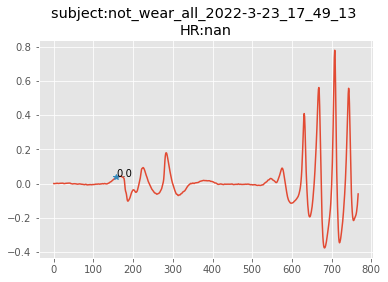

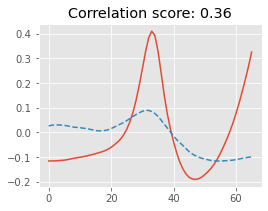

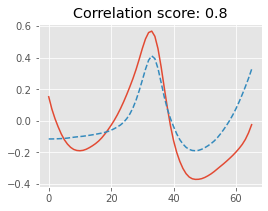

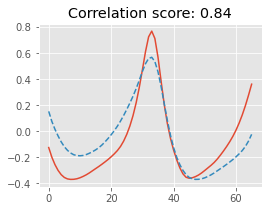

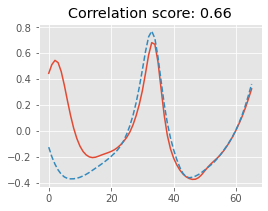

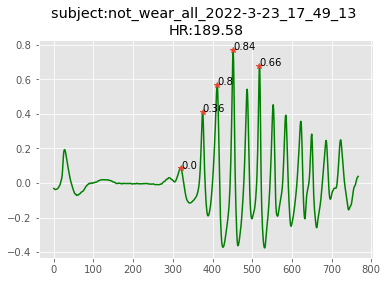

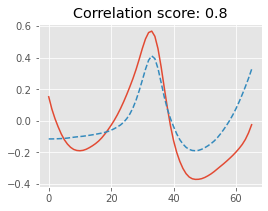

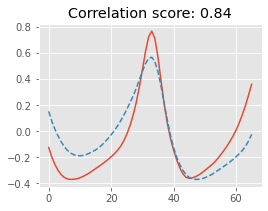

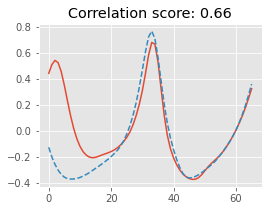

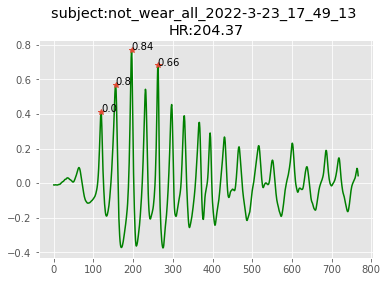

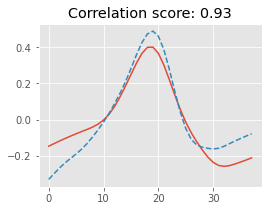

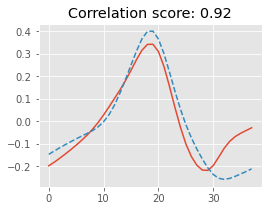

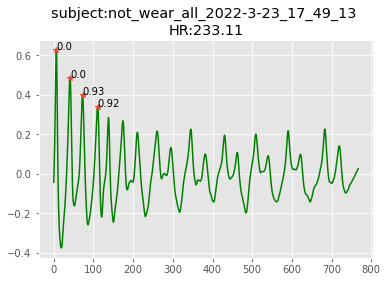

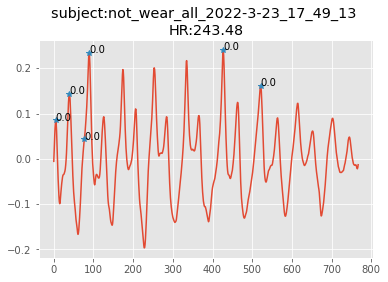

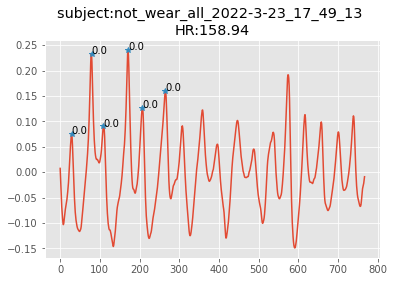

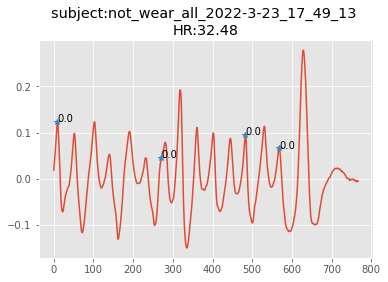

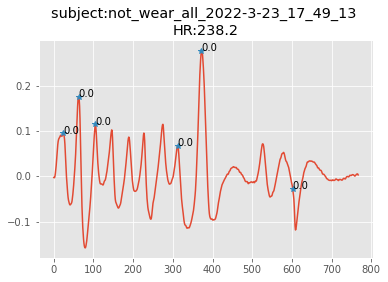

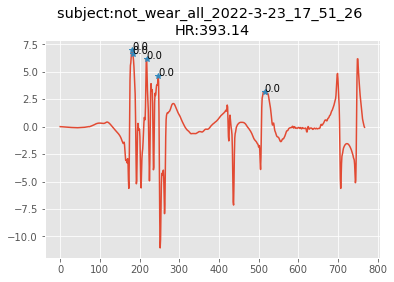

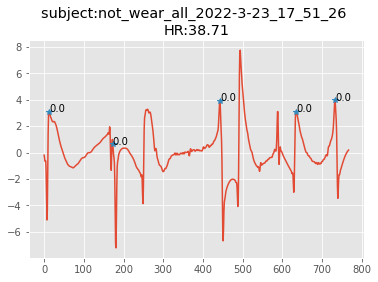

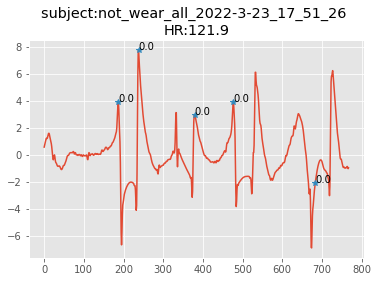

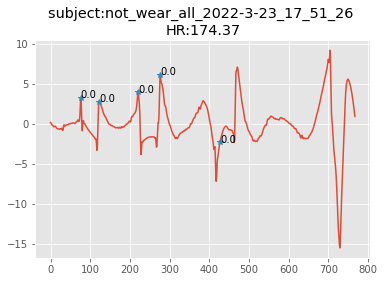

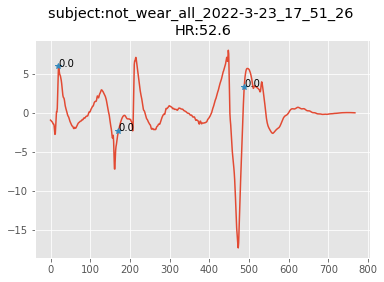

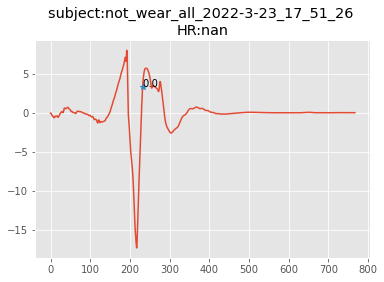

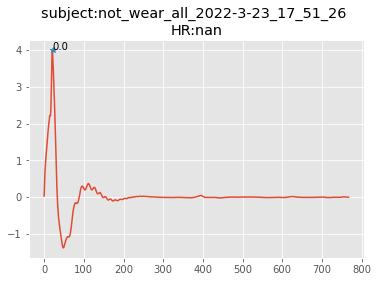

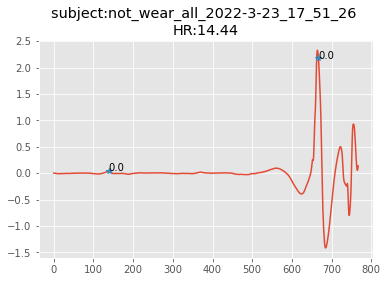

In [37]:

folder = 'test/wearing'
# subjects = ['Shawn_wear', 'Shawn_standup', 'Rick_wear_3']
# subjects = ['all_2022-3-3_10_32_25_shawn', 'all_2022-3-3_10_34_15_shawn', 'all_2022-3-3_10_37_15_Jason']
# subjects = ['all_2022-3-4_13_49_16_rick', 'all_2022-3-4_13_51_52_jason', 'all_2022-3-4_13_54_0_jason2'] 
# subjects = ['all_2022-3-4_14_48_9_shawn', 'all_2022-3-4_16_21_54_rayn ok', 'all_2022-3-9_11_32_47_rick', 'all_2022-3-9_14_26_3_rick1', 'all_2022-3-9_14_51_55_shawn', 'all_2022-3-22_15_30_23_rick配戴'] 
subjects = ['not_wear_all_2022-3-23_17_49_13', 'not_wear_all_2022-3-23_17_51_26'] 
# subjects = ['all_2022-3-24_11_19_58_ryan']
# subjects = ['all_2022-3-22_16_10_10_not_wear']
sr = 128

# Filter parameters
b, a = sp.bp_filter(0.8, 3, sr, 4)
# d, c = sp.bp_filter(0.8, 3, sr, 4)


window = sr*6
n_window = 8
step = 2*sr
start_sec = 0

for subject in subjects:
    full_file_path = os.path.join("../../data", 'stark', folder, )
    data = file_read.csv_reader(full_file_path, subject)
    # ppg_data= file_read.csv_reader(full_file_path, 'ppg')
    # ecg_data= file_read.csv_reader(full_file_path, 'ecg') 
    
    
    for n in range(n_window):
        s1 = start_sec*sr + n*step
        s2 = s1 + window
        
        accX_segment = data['accX'][s1:s2]
        accY_segment = data['accY'][s1:s2]
        accZ_segment = data['accZ'][s1:s2]
        # ECG preprocessing
        ecg_segment = data['ecg'][s1:s2]
        ecg_proc = ecg.ecg_preprocess(ecg_segment, sr)
        ecg_proc = np.array(ecg_proc)
        ecg_hr_list, rpeak = ecg.ecg_hr_estimate(ecg_proc, sr)
        filt_ecg = ecg.final_filter(ecg_segment, sr, 4)
        ecg_hr = np.round(np.mean(ecg_hr_list),2)
        # rpeak_loc, _ = find_peak(sr, filt_ecg)
        
        # -------------------------------------------------------------
        # PPG preprocessing 
        ppg_segment = data['IR'][s1:s2]
        filt_ppg = signal.filtfilt(b, a, ppg_segment)
        
        # -------------------------------------------------------------
        refine_rpeak = local_max(filt_ecg, rpeak)
    
        is_good, xcorr_list = q_check(sr, refine_rpeak, filt_ecg)
      
        
        ''' plot ppg and ecg'''
        plot_title = 'subject:{} \n'.format(subject)
        plot_title = plot_title + 'HR:{}'.format(ecg_hr)
        # plot_title = plot_title + 'num HR:{}, num rpeak:{}\n'.format(len(ecg_hr_list), len(rpeak))
     
        plt.figure(figsize=(6,4))
        plt.title(plot_title)
        if is_good:
            plt.plot(filt_ecg, color='green')    
        else:
            plt.plot(filt_ecg)
            
        plt.plot(refine_rpeak, filt_ecg[refine_rpeak], '*')
        for i in range(len(refine_rpeak)):
            plt.text(refine_rpeak[i], filt_ecg[refine_rpeak[i]], str(np.round(xcorr_list[i],2)))
            
            
        plt.savefig('../../figure/' + subject + '_' +str(s1/sr)+'.png')
        
        
        '''plot'''
        # fig = plt.figure(figsize = (21 ,3))
        # ax1 = fig.add_subplot(131)
        # ax2 = fig.add_subplot(132)
        # ax3 = fig.add_subplot(133)
    
        # if not is_good:
        #     plot_title = plot_title + 'Bad rr interval! ' 
    
    
        # ax1.set_title(plot_title)
        # if is_good:
        #     ax1.plot(filt_ecg, color='green')    
        # else:
        #     ax1.plot(filt_ecg)
        # ax1.plot(rpeak, filt_ecg[rpeak], 'v')
        
        # ax2.plot(ecg_proc)
        # ax2.plot(rpeak, ecg_proc[rpeak], '*')

        # # Plot acc
        # ax3.plot(accX_segment, label='acc X')
        # ax3.plot(accY_segment, label='acc Y')
        # ax3.plot(accZ_segment, label='acc Z')
        # ax3.legend()

In [14]:
def bpm2rr(bpm):
    print('rr:{} sec'.format(60/bpm))
    
bpm2rr(100)

bpm2rr(60)



rr:0.6 sec
rr:1.0 sec


In [15]:
1/0.6

1.6666666666666667